In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
from Bio import SeqIO
import csv
from pandas import DataFrame
import seaborn as sns


# Initialization

In [3]:
tool="Oases"
sample="NA12878"

ref_gtf_gencode="/path/to/gencode.v19.annotation.gtf"
transcript_file="/path/to/transcripts.fa"
cuffcompare="/path/to/cufflinks-2.2.1.Linux_x86_64/cuffcompare"


# Predictions

In [4]:

gmap_alignment_psl="/path/to/transcripts.fa.psl"
gmap_alignment_gff="/path/to/transcripts.fa.gff"
expression_files={"eXpress":"/path/to/results.xprs",
                  "kallisto":"/path/to/abundance.tsv"}
trinity_pkg_folder="/path/to/trinityrnaseq-2.1.1/"


# Functions

In [5]:
def fix_name_for_trinity_analysis(input_file,tool):
    renamed_file=input_file+".renamed"
    fasta_sequences = SeqIO.parse(open(input_file),'fasta')
    
    new_seq = []
    with open(renamed_file, 'w') as renamed_f:
        for record in fasta_sequences:
            rid=record.description
            if tool in["SOAPdenovo","SOAPdenovo_ds"]:
                if "Locus" in rid:
                    s=rid.split(" ")
                    gene=int(s[1].split("_")[1])
                    isoform=int(s[1].split("_")[2])+1
                    name="Locus"
                else:
                    s=rid.split(" ")
                    gene=1
                    isoform=1
                    name=s[0]
                new_record_name = "%s_c0_g%s_i%s len=%s"%(name,gene,isoform,len(record.seq)) 
            elif tool=="Oases":
                s=rid.split("_")
                gene=int(s[1])
                isoform=int(s[3].split("/")[0])
                name="Locus"
                new_record_name = "%s_c0_g%s_i%s len=%s"%(name,gene,isoform,len(record.seq)) 
            record.id = new_record_name
            record.name = ''
            record.description = ''
            new_seq.append(record)
        SeqIO.write(new_seq, renamed_f, 'fasta')



In [6]:
def filter_small_isoforms(input_file,Lmin):
    fasta_sequences = SeqIO.parse(open(input_file),'fasta')
    filtered_file=input_file+".g%d"%Lmin
    new_seq = []
    with open(filtered_file, 'w') as filtered_f:
        for record in fasta_sequences:
            rid=record.description
            if len(record.seq)>Lmin:
                new_seq.append(record)
        SeqIO.write(new_seq, filtered_f, 'fasta')



In [7]:
def collect_small_isoforms(input_file,Lmin):
    fasta_sequences = SeqIO.parse(open(input_file),'fasta')
    id_file=input_file+".g%d.pickle"%Lmin
    new_seq = []
    with open(id_file, 'w') as id_f:
        for record in fasta_sequences:
            rid=record.description
            if len(record.seq)>Lmin:
                new_seq.append(rid.split(" ")[0])
        pickle.dump(new_seq, id_f)



In [8]:
def generate_small_gff(gff_file,transcript_file,Lmin):
    small_file=transcript_file+".g%d.pickle"%Lmin
    small_ids= pickle.load(open(small_file))
    print len(small_ids),len(set(small_ids))
    small_gff_file=gff_file+".g%d"%Lmin
    with open(gff_file, 'r') as in_f:
        with open(small_gff_file, 'w') as out_f:
            spamreader = csv.reader(in_f, delimiter='\t', quotechar='|')
            spamwriter = csv.writer(out_f, delimiter='\t',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
            for row in spamreader:
                if row[0][0]=="#":
                    continue
                t_dict=dict(map(lambda x:x.split("="),row[8].split(";")))
                tid=t_dict["ID"].split(".")[0]
                if tid in small_ids:
                    spamwriter.writerow(row)



In [9]:
def parse_trinitystat(stat_file):
    stat={}
    with open(stat_file, 'r') as input_f:
        ex=""
        for line in input_f:
            if "Stats based on ALL transcript contigs:" in line:
                ex="_all"
            elif "Stats based on ONLY LONGEST ISOFORM per 'GENE':" in line:
                ex="_long"
            if (line[0] == '#'):
                continue
            line=line.strip()
            if not line:
                continue
            fields=line.split(":")
            stat[fields[0]+ex]=fields[1].strip()
    return stat

In [10]:
def parse_trinitystat_exn50(stat_file,exp_method):
    stat={}
    with open(stat_file, 'r') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        mat=[]
        for row in spamreader:
            if row[0][0]=="#":
                continue
            mat.append([int(row[0][1:]),float(row[1]),int(row[2]),int(row[3])])
        stat["EX_N50_%s"%exp_method]=mat
    return stat

In [11]:
def parse_psl(psl_file):
    stat={}
    with open(psl_file, 'r') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        p_identity=[]
        p_identity_g300=[]
        l_p=[]
        for row in spamreader:
            n_match=row[0]
            n_match_rep=row[2]
            l_trans=int(row[10])
            p_identity.append(int(float(n_match)/float(l_trans)*100))
            l_p.append([l_trans,int(float(n_match)/float(l_trans)*100)])
            if l_trans>300:
                p_identity_g300.append(int(float(n_match)/float(l_trans)*100))
                
        h={i:p_identity.count(i) for i in range(101)}
        h_g300={i:p_identity_g300.count(i) for i in range(101)}
        if sum(h.values())!=len(p_identity):
            print "Erorr"
        stat["hist_gmap_identity"]=h
        stat["l_and_p"]=l_p
        stat["hist_gmap_identity_g300"]=h_g300
    return stat

In [12]:
def parse_cuffcmp(stat_file):
    stat={}
    with open(stat_file, 'r') as input_f:
        for line in input_f:
            if (line[0] == '#'):
                if (not "Query mRNAs" in line) and (not "multi-transcript loci" in line):
                    continue
            line=line.strip()
            if not line:
                continue
            fields=line.split("\t")
            if not fields:
                continue
            if "Query mRNAs" in line:
                stat["n_t"]=int(line.split(":")[-1].split("in")[0].strip())
                stat["n_loci"]=int(line.split(":")[-1].split("in")[1].split("loci")[0].strip())
                stat["n_multiexon"]= int(line.split(":")[-1].split("(")[1].split("multi")[0].strip())
            elif "multi-transcript loci" in line:
                stat["n_multitrans"]= int(line.split("(")[1].split("multi")[0].strip())
                stat["trans_per_loci"]= float(line.split("~")[1].split("trans")[0].strip())
            elif "level" in fields[0]:
                vs=[float(v.strip()) if "-" not in v else v.strip() for v in fields[1:]]
                kys=["Sn","Sp","fSn","fSp"]
                k="_".join(fields[0].strip().split(":")[0].split())
                for i in range(4):
                    stat["%s_%s"%(k,kys[i])]=vs[i] 
            elif len(fields)==1:
                k,v=fields[0].split(":")
                stat["_".join(k.strip().split())]=int(v.strip())
            else:
                k,v=fields[0].split(":")
                k="_".join(k.strip().split())
                v1,v2=v.strip().split("/")
                p=fields[1].split("(")[-1].strip().split("%")[0]
                stat[k+'_1']=int(v1)
                stat[k+'_2']=int(v2)
                stat[k+'_r']=float(p)
    return stat

In [13]:
def sort_gff(in_file,out_file,order_chrs=dict([("%s"%k,k) for k in range(1,23)]+[("MT",23),("X",24),("Y",25)])):
    with open(in_file) as csv_file:
        headers=[]
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        rows=[]
        for row in spamreader:
            if row[0][0]=="#":
                headers.append(row)
            else:
                rows.append(row)
        sorted_rows=sorted(rows,key=lambda x: (order_chrs[x[0]],int(x[3])))
        with open(out_file, 'wb') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter='\t',
                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerows(headers)
            spamwriter.writerows(sorted_rows)


In [14]:
def find_splits(tracking_file):
    n=0
    a=0
    with open(tracking_file) as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        ts=[]
        for row in spamreader:
            a+=1
            code=row[3]
            if code not in ["c"]:
                continue
            ts.append(row[2])
        n=sum([ts.count(i) for i in set(ts) if ts.count(i)>1])
    return n,a
    


# Analysis

## Read Assembly transcripts

In [15]:
dnv_stats={}

In [16]:
fasta_sequences = SeqIO.parse(open(transcript_file),'fasta')
sequences={}
bases={}
lens=[]
for fasta in fasta_sequences:
    sequence = str(fasta.seq)
    base_dict={x: sequence.count(x) for x in set(sequence)}
    lens.append(len(sequence))
    for k,v in base_dict.iteritems():
        if k not in bases:
            bases[k]=0
        bases[k]+=v
hist_l={ x: lens.count(x) for x in set(lens)}

dnv_stats.update({"n_trans":len(lens),\
                               "bases":bases,\
                               "hist_l":hist_l,\
                               "n_l_200":sum(map(lambda x: x[1] if x[0]>200 else 0,hist_l.items())),\
                               "n_l_200":sum(map(lambda x: x[1] if x[0]>300 else 0,hist_l.items())),\
                               })

In [17]:
if not os.path.exists(transcript_file+".renamed"):
    fix_name_for_trinity_analysis(transcript_file,tool)

In [18]:
Lmin=300
if not os.path.exists(transcript_file+".g%d"%Lmin):
    filter_small_isoforms(fname,Lmin)


## Run Trinity analysis

In [19]:
cmd="%s/util/TrinityStats.pl \
          %s.renamed > %s.trinitystats"%(trinity_pkg_folder,transcript_file,transcript_file)
if not os.path.exists("%s.trinitystats"%transcript_file):
    print cmd
    a=os.system(cmd)
    if a!=0:
        print a
dnv_stats.update(parse_trinitystat("%s.trinitystats"%transcript_file))


In [20]:
for expression in ["eXpress","kallisto"]:
    expression_file=expression_files[expression]
    if not os.path.exists("%s.ExN50.stats"%expression_file):
        if not os.path.exists("%s.trans_counts.TMM.EXPR.matrix"%expression_file):
            cmd="%s/util/abundance_estimates_to_matrix.pl \
                      --est_method %s  --out_prefix %s.trans_counts \
                      %s\
                      "%(trinity_pkg_folder,expression, expression_file,expression_file)
            print cmd
            a=os.system(cmd)
            if a!=0:
                print a
        if os.path.exists("%s.trans_counts.TMM.EXPR.matrix"%expression_file):
            cmd="%s/util/misc/contig_ExN50_statistic.pl \
                      %s.trans_counts.TMM.EXPR.matrix %s\
                      | tee %s.ExN50.stats\
                      "%(trinity_pkg_folder,expression_file,transcript_file,expression_file)
            print cmd
            a=os.system(cmd)
            if a!=0:
                print a

    dnv_stats.update(parse_trinitystat_exn50("%s.ExN50.stats"%expression_file,expression))


## Parse GMAP output 

In [21]:
dnv_stats.update(parse_psl(gmap_alignment_psl))

In [22]:
unsorted_gff_file="%s.gff"%(transcript_file)
gff_file="%s.gff.sorted"%(transcript_file)
if not os.path.exists(gff_file):
    sort_gff(unsorted_gff_file,gff_file)

cmd="%s -o \
          %s.cuffcmp_gencode -r \
          %s -R %s"%(cuffcompare,transcript_file,ref_gtf_gencode,gff_file)
if not os.path.exists("%s.cuffcmp_gencode.stats"%transcript_file):
    print cmd
    a=os.system(cmd)
    if a!=0:
        print a


In [23]:
stat_path="%s.cuffcmp_gencode.stats"%(transcript_file) 
dnv_stats.update(parse_cuffcmp(stat_path))

In [24]:
Lmin=300
unsorted_gff_file="%s.g%d.gff"%(transcript_file,Lmin)
gff_file="%s.g%d.gff.sorted"%(transcript_file,Lmin)
sort_gff(unsorted_gff_file,gff_file)
cmd="%s -o \
          %s.cuffcmp_gencode_g%d -r \
          %s -R %s"%(cuffcompare,transcript_file,Lmin,ref_gtf_gencode,gff_file)
if not os.path.exists("%s.cuffcmp_gencode_g%d.stats"%(transcript_file,Lmin)):
    a=os.system(cmd)
    if a!=0:
        print a


In [25]:
fasta_file=(transcript_file)
stat_path="%s.cuffcmp_gencode_g%d.stats"%(transcript_file,Lmin) 
s=parse_cuffcmp(stat_path)
s_={}
for k,v in s.iteritems():
    new_k="%s_g%d"%(k,Lmin)
    if new_k in dnv_stats:
        print new_k
        aaaaa
    s_[new_k]=v
dnv_stats.update(s_)

## Plots

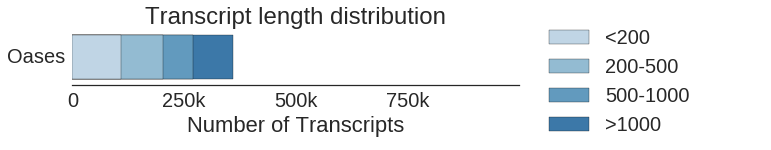

In [26]:
sns.set(style="white",font_scale=2)    
my_palette_2=sns.color_palette("Blues",n_colors=6)
my_palette=[my_palette_2[4],my_palette_2[3],my_palette_2[2],my_palette_2[1]]

bins=[0,200,500,1000,10000000]
bin_labels=[]
for i in range(1,len(bins)):
    if 1<i<len(bins)-1:
        bin_labels.append("%s-%s"%(bins[i-1],bins[i]))
    elif i==1:
        bin_labels.append("<%s"%(bins[i]))
    else:
        bin_labels.append(">%s"%(bins[i-1]))
bin_labels=bin_labels[::-1]
fig, ax = plt.subplots(figsize=(8,1))
res=[]
for b in bins[::-1][:-1]:
    res_bin=[]
    hist_l=dnv_stats["hist_l"]
    L=float(dnv_stats["n_trans"])
    res_bin.append(sum(map(lambda x: x[1] if x[0]<=b else 0,hist_l.items())))
    labels=[tool]
    res.append(res_bin)

my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels)
for ii,b in enumerate(bin_labels):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[ii],ax=ax)
sns.despine(left=True)  

ax.set_xticks(range(0,800000,250000))
ax.set_xlim([0,1000000])
ax.set_xticklabels(["%sk"%(x/1000) if x>0 else "0" for x in range(0,800000,250000)])

ax.set_xlabel("Number of Transcripts")
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.05, 0.85, 0.5, .3), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)

ax.set_title("Transcript length distribution")

In [27]:
keys=["n_loci_g300","n_t_g300"]
labels=["Number of predicted genes","Number of predicted transcripts"]
for i,k in enumerate(keys):
    print labels[i],int(dnv_stats[k])


Number of predicted genes 92907
Number of predicted transcripts 219184


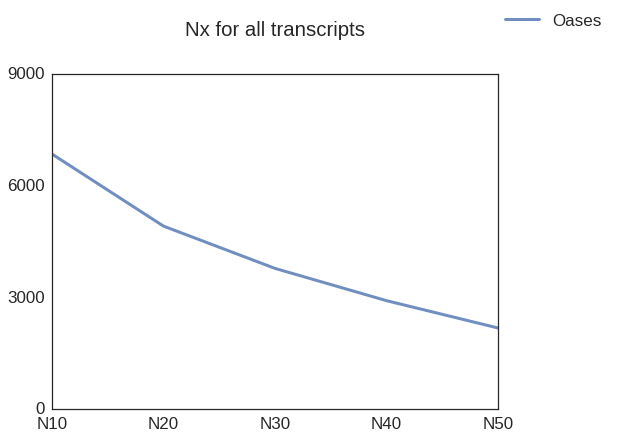

In [28]:
sns.set(style="white",font_scale=1.7)    
fig, ax = plt.subplots(figsize=(8,6))
keys=["Contig N10_all","Contig N20_all","Contig N30_all","Contig N40_all","Contig N50_all"]
labels=["N10","N20","N30","N40","N50"]
z=[dnv_stats[k] for k in keys]
index = np.arange(len(z))
bar_width = 0.2
opacity = 0.5
rects1 = ax.plot(index, z, alpha=0.8,
                 label=tool, linewidth=3)
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.set_yticks(range(0,12000,3000))
ax.set_ylim([0,9000])
ax.legend(bbox_to_anchor=(1, 1.1, 0.3, .102), loc=2,ncol=4,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Nx for all transcripts",y=1.1)

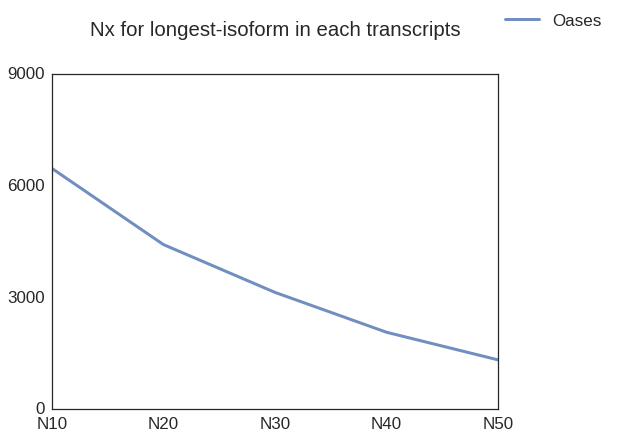

In [29]:
sns.set(style="white",font_scale=1.7)    
fig, ax = plt.subplots(figsize=(8,6))
keys=["Contig N10_long","Contig N20_long","Contig N30_long","Contig N40_long","Contig N50_long"]
labels=["N10","N20","N30","N40","N50"]
z=[dnv_stats[k] for k in keys]
index = np.arange(len(z))
bar_width = 0.2
opacity = 0.5
rects1 = ax.plot(index, z, alpha=0.8,
                 label=tool, linewidth=3)
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.set_yticks(range(0,12000,3000))
ax.set_ylim([0,9000])
ax.legend(bbox_to_anchor=(1, 1.1, 0.3, .102), loc=2,ncol=4,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Nx for longest-isoform in each transcripts",y=1.1)

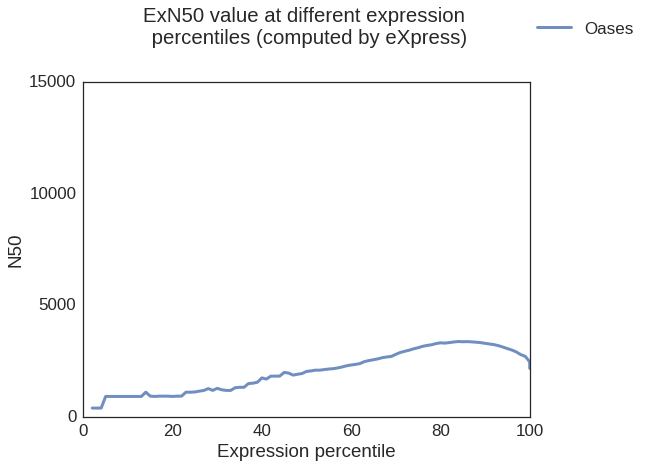

In [30]:
sns.set(style="white",font_scale=1.7)    
fig, ax = plt.subplots(figsize=(8,6))
keys=["Contig N10_long","Contig N20_long","Contig N30_long","Contig N40_long","Contig N50_long"]
labels=["N10","N20","N30","N40","N50"]
labels=[tool]
mx=0
z=dnv_stats["EX_N50_eXpress"]
x=map(lambda x:x[0],z)
y=map(lambda x:x[2],z)
mx=max(mx,max(y))
opacity = 0.5
rects1 = ax.plot(x,y, alpha=0.8,label=tool,
                        linewidth=3)
ax.set_ylabel("N50")
ax.set_yticks(range(0,20000,5000))
ax.legend(bbox_to_anchor=(1, 1.1, 0.3, .102), loc=2,ncol=4,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_xlabel("Expression percentile")
ax.set_title("ExN50 value at different expression \n percentiles (computed by eXpress)",y=1.1)


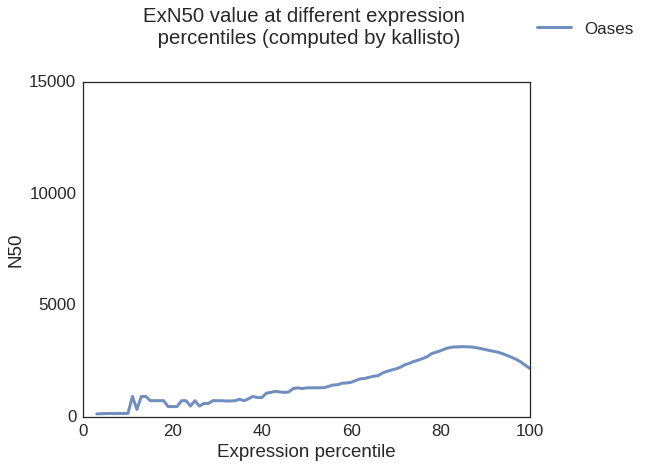

In [31]:
sns.set(style="white",font_scale=1.7)    
fig, ax = plt.subplots(figsize=(8,6))
keys=["Contig N10_long","Contig N20_long","Contig N30_long","Contig N40_long","Contig N50_long"]
labels=["N10","N20","N30","N40","N50"]
labels=[tool]
mx=0
z=dnv_stats["EX_N50_kallisto"]
x=map(lambda x:x[0],z)
y=map(lambda x:x[2],z)
mx=max(mx,max(y))
opacity = 0.5
rects1 = ax.plot(x,y, alpha=0.8,label=tool,
                        linewidth=3)
ax.set_ylabel("N50")
ax.set_yticks(range(0,20000,5000))
ax.legend(bbox_to_anchor=(1, 1.1, 0.3, .102), loc=2,ncol=4,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("ExN50 value at different expression \n percentiles (computed by kallisto)",y=1.1)
ax.set_xlabel("Expression percentile")


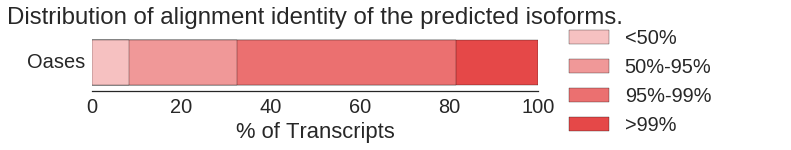

In [32]:
sns.set(style="white",font_scale=2)    
my_palette_1=sns.light_palette("red",n_colors=6)
my_palette=[my_palette_1[4],my_palette_1[3],my_palette_1[2],my_palette_1[1]]

bins=[0,50,95,99,100]
bin_labels=[]
for i in range(1,len(bins)):
    if 1<i<len(bins)-1:
        bin_labels.append("%s%%-%s%%"%(bins[i-1],bins[i]))
    elif i==1:
        bin_labels.append("<%s%%"%(bins[i]))
    else:
        bin_labels.append(">%s%%"%(bins[i-1]))
bin_labels=bin_labels[::-1]
fig, ax = plt.subplots(figsize=(8,1))
res=[]
for b in bins[::-1][:-1]:
    res_bin=[]
    hist_l=dnv_stats["hist_gmap_identity_g300"]
    res_bin.append(sum(map(lambda x: x[1]/float(sum(hist_l.values()))*100 if x[0]<=b else 0,hist_l.items())))
    labels=[tool]
    res.append(res_bin)

my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels)
for ii,b in enumerate(bin_labels):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[ii],ax=ax)
sns.despine(left=True)  

ax.set_xlim([0,100])

ax.set_xlabel("% of Transcripts")
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.05, 0.95, 0.5, .3), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Distribution of alignment identity of the predicted isoforms.",y=1.1)


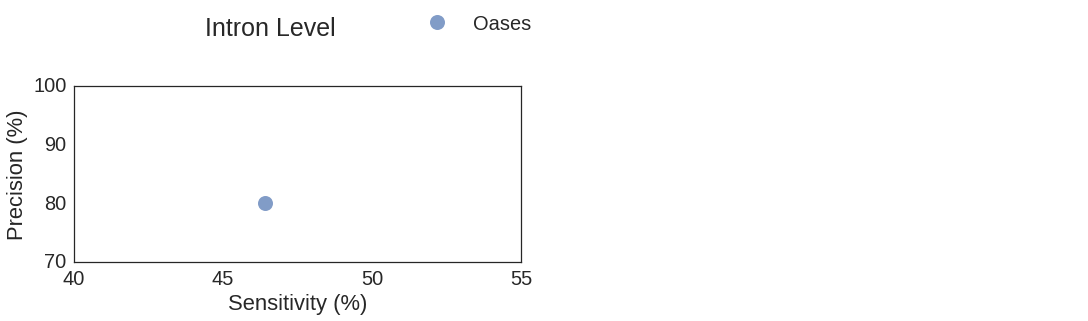

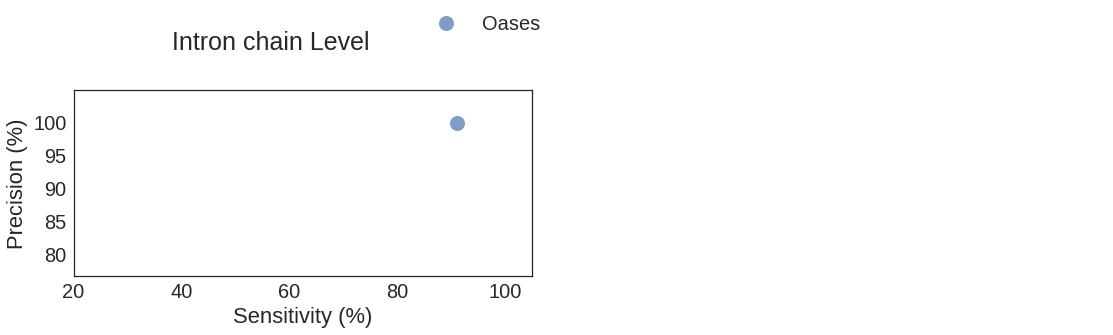

In [33]:
sns.set(style="white",font_scale=2)    
dict_levels={"Intron":"Intron","Intron chain":"Intron_chain"}
pls=["Intron","Intron chain"]
for pl in pls:
    kl=dict_levels[pl]
    fig, ax = plt.subplots(figsize=(8,4))
    labels=[tool]
    legs=[]
    A=(dnv_stats["%s_level_fSn"%(kl)])
    B=(dnv_stats["%s_level_fSp"%(kl)])
    ax.plot(A, B, alpha=0.7, linestyle="",
            linewidth=3,marker="o",markersize=15)
    legs.append(tool)
    ax.set_xlabel("Sensitivity (%)")
    ax.set_ylabel("Precision (%)")
    if pl=="Intron":
        ax.set_xlim([40,55])
        ax.set_xticks(range(40,60,5))
        ax.set_ylim([70,100])
        ax.set_yticks(range(70,110,10))
    elif pl=="Intron chain":
        ax.set_xlim([20,105])
        ax.set_xticks(range(20,120,20))
        ax.set_ylim([77,105])
        ax.set_yticks(range(80,105,5))

    plt.tight_layout()
    ax.legend(legs,bbox_to_anchor=(0.75, 1.35, 1.5, .102), loc=2,ncol=1,
              mode="expand", borderaxespad=0.,frameon=False)
    suptitle("%s Level"%(pl),fontsize=25,y=1.12)


In [34]:
fasta_file="%s.g300"%(transcript_file)
tracking_file="%s.cuffcmp_gencode_g300.tracking"%(transcript_file)
n,a=find_splits(tracking_file)
contained={"n":n,"a":a}


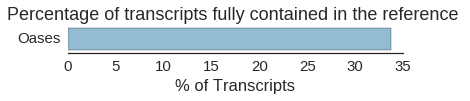

In [35]:
sns.set(style="white",font_scale=1.5)    

my_palette_2=sns.color_palette("Blues",n_colors=6)
my_palette=[my_palette_2[4],my_palette_2[3],my_palette_2[2],my_palette_2[1]]

fig, ax = plt.subplots(figsize=(6,0.5))
res_bin=[contained["n"]/float(contained["a"])*100]
labels=[tool]

res=[res_bin]
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=["C"])
cg=sns.barplot(data=my_data,x="C",y=labels, color=my_palette[2],ax=ax)
ax.set_xlabel("% of Transcripts")
sns.despine(left=True)    
ax.set_title("Percentage of transcripts fully contained in the reference ")